<div style="text-align: center; background-color: #559cff; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  📌  Trực Quan Hóa Dữ Liệu - 21_21 📌
  
   Lab 1
</div>

# 4 Model

## 4.0 Bài toán đặt ra

- Các cơ quan cảnh sát địa phương, trung ương và các công ty bảo hiểm muốn xây dựng một hệ thống phân loại nhằm các mục đích lần lượt sau:
    - **Tối ưu các nguồn lực cứu hộ :** Việc phân loại nhanh mức độ của vụ tai nạn có thể giúp các cơ quan công an, bộ phận cứu thương có thể phân phối những nguồn lực con người, trang thiết bị phù hợp, điều này giúp tối ưu thời gian và chi phí giải quyết.
    - **Chính sách bảo hiểm :** Dựa thêm các yếu tố liên quan, các công ty bảo hiểm có thể dự tính nhanh chóng các khoản chi phí bảo hiểm cho khách hàng, là xe, cá nhân bị tai nạn giao thông.
- Cách thực hiện :
    - Xây dựng một mô hình phân lớp bằng thư viện `PyTorch` theo các bước cơ bản sau đây:
        - Chuẩn bị và xử lí dữ liệu như :xử lí outlier, missing, mã hoá dữ liệu, chuẩn hoá dữ liệu.
        - Tạo mô hình theo trình tự: định nghĩa mô hình, chọn hàm mất mát, bộ tối ưu hoá,...
        - Huấn luyện mô hình và lưu lại mô hình.
        - Đánh giá chất lượng dựa trên tập test.

In [253]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [254]:
df = pd.read_csv("data/US_Accidents_processed.csv")
time_cols=['Start_Time','End_Time','Weather_Timestamp']
for col in time_cols:
    df[col]=pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S.%f')
    #df[col]=pd.to_datetime(df[col], format='mixed')

## 4.1 Xử lí dữ liệu bị thiếu

- Trước hết ta kiểm tra xem dữ liệu có đang bị thiếu ở cột nào hay không ?

In [255]:
# Lặp qua các cột số để tính tỉ lệ giá trị thiếu
missing_percentages = [(col, df[col].isnull().mean() * 100) for col in list(df.columns)]

# Sắp xếp theo tỉ lệ giảm dần
missing_percentages.sort(key=lambda x: x[1], reverse=False)

# Tạo DataFrame từ list
missing_df = pd.DataFrame(missing_percentages, columns=['Cột', 'Tỉ lệ giá trị thiếu (%)'])
missing_df.sort_values(by='Tỉ lệ giá trị thiếu (%)', ascending=False, inplace=True)

#Chọn ra top 10 
missing_df[:10]

,Cột,Tỉ lệ giá trị thiếu (%)
35,Weather_Timestamp,1.557504
1,Start_Time,0.000000
20,Bump,0.000000
21,Crossing,0.000000
22,Give_Way,0.000000
23,Junction,0.000000
24,No_Exit,0.000000
25,Railway,0.000000
26,Roundabout,0.000000
27,Station,0.000000


- Tỷ lệ mất mát không quá cao, nên ta có thể xoá đi những dòng dữ liệu bị missed ở cột  `Weather_Timestamp`

In [256]:
#Điền nan cho những cột còn thiếu
print(df.shape)
df = df.dropna(subset=['Weather_Timestamp']).reset_index(drop=True)
print(df.shape)

(772839, 36)
(760802, 36)


## 4.1 Xử lí Outlier bằng IQR

In [257]:
numerical_cols = df.select_dtypes(include=[np.number]).columns

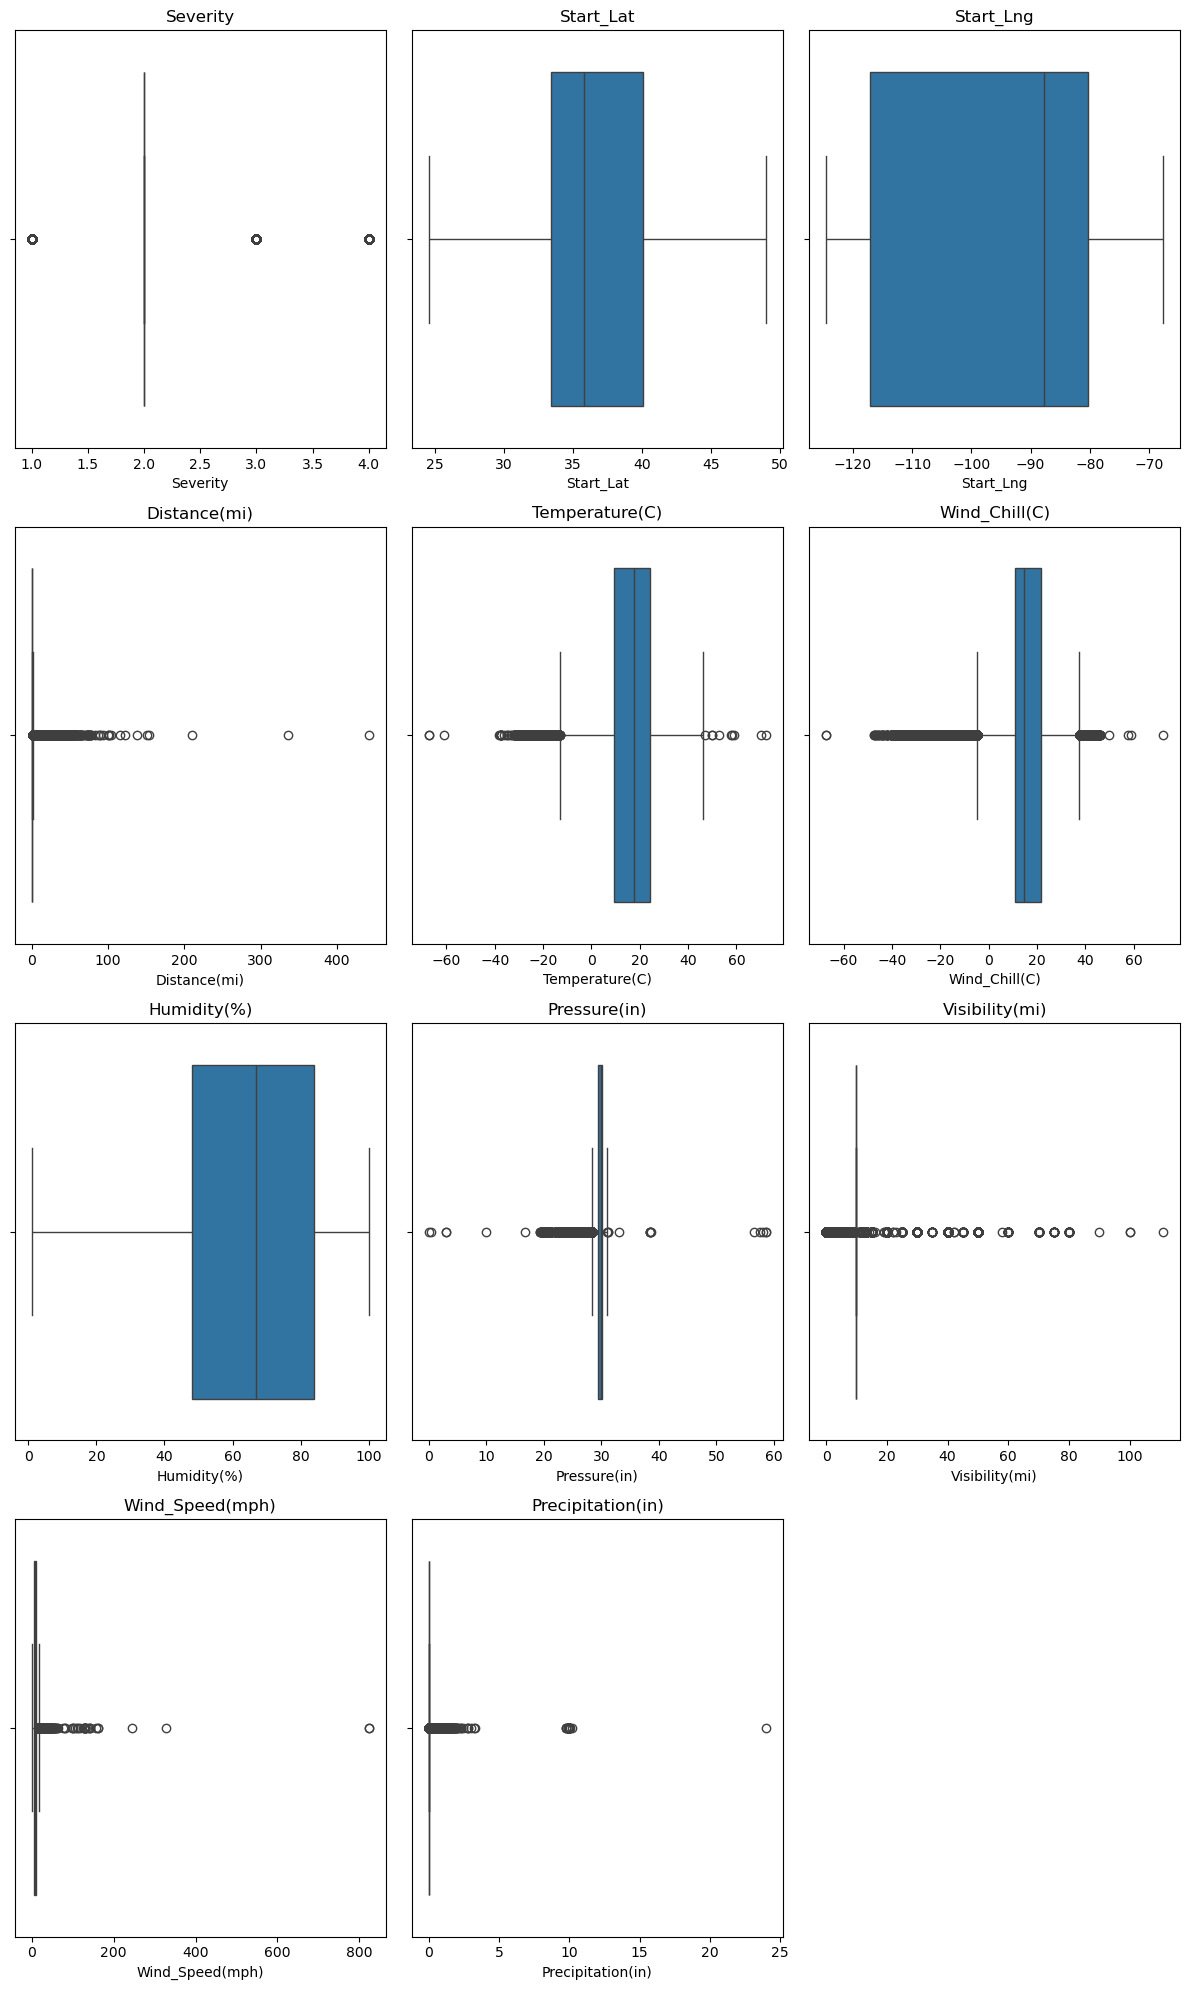

In [258]:
num_cols = 3
num_rows = (len(numerical_cols) - 1) // num_cols + 1

# Tạo figure và axes cho boxplot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 5*num_rows))

# Lặp qua các cột số để vẽ boxplot
for i, col in enumerate(numerical_cols):
    row = i // num_cols
    col_name = col  # Lưu tên cột
    col = i % num_cols
    sns.boxplot(x=df[col_name], ax=axes[row, col]) 
    axes[row, col].set_title(col_name)  

# Xóa các axes dư thừa nếu có
for i in range(len(numerical_cols), num_rows*num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

- Cột `Severity` thể hiện mức độ nghiêm trọng, có giá trị từ 1 - 4 nên chúng ta không cần xử lí outlier. 
- Các cột còn lại xử lí outlier bằng IQR.

In [259]:

col_with_outliers = [col for col in numerical_cols if col != 'Severity']

def handle_outlier(col_to_handle: list, df):
    for col in col_to_handle:

        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        

        IQR = Q3 - Q1
        
        # tính khoảng 1.5 IQR
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Replace outliers with values based on IQR
        df[col] = df[col].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))
    
    return df


df = handle_outlier(col_with_outliers, df)

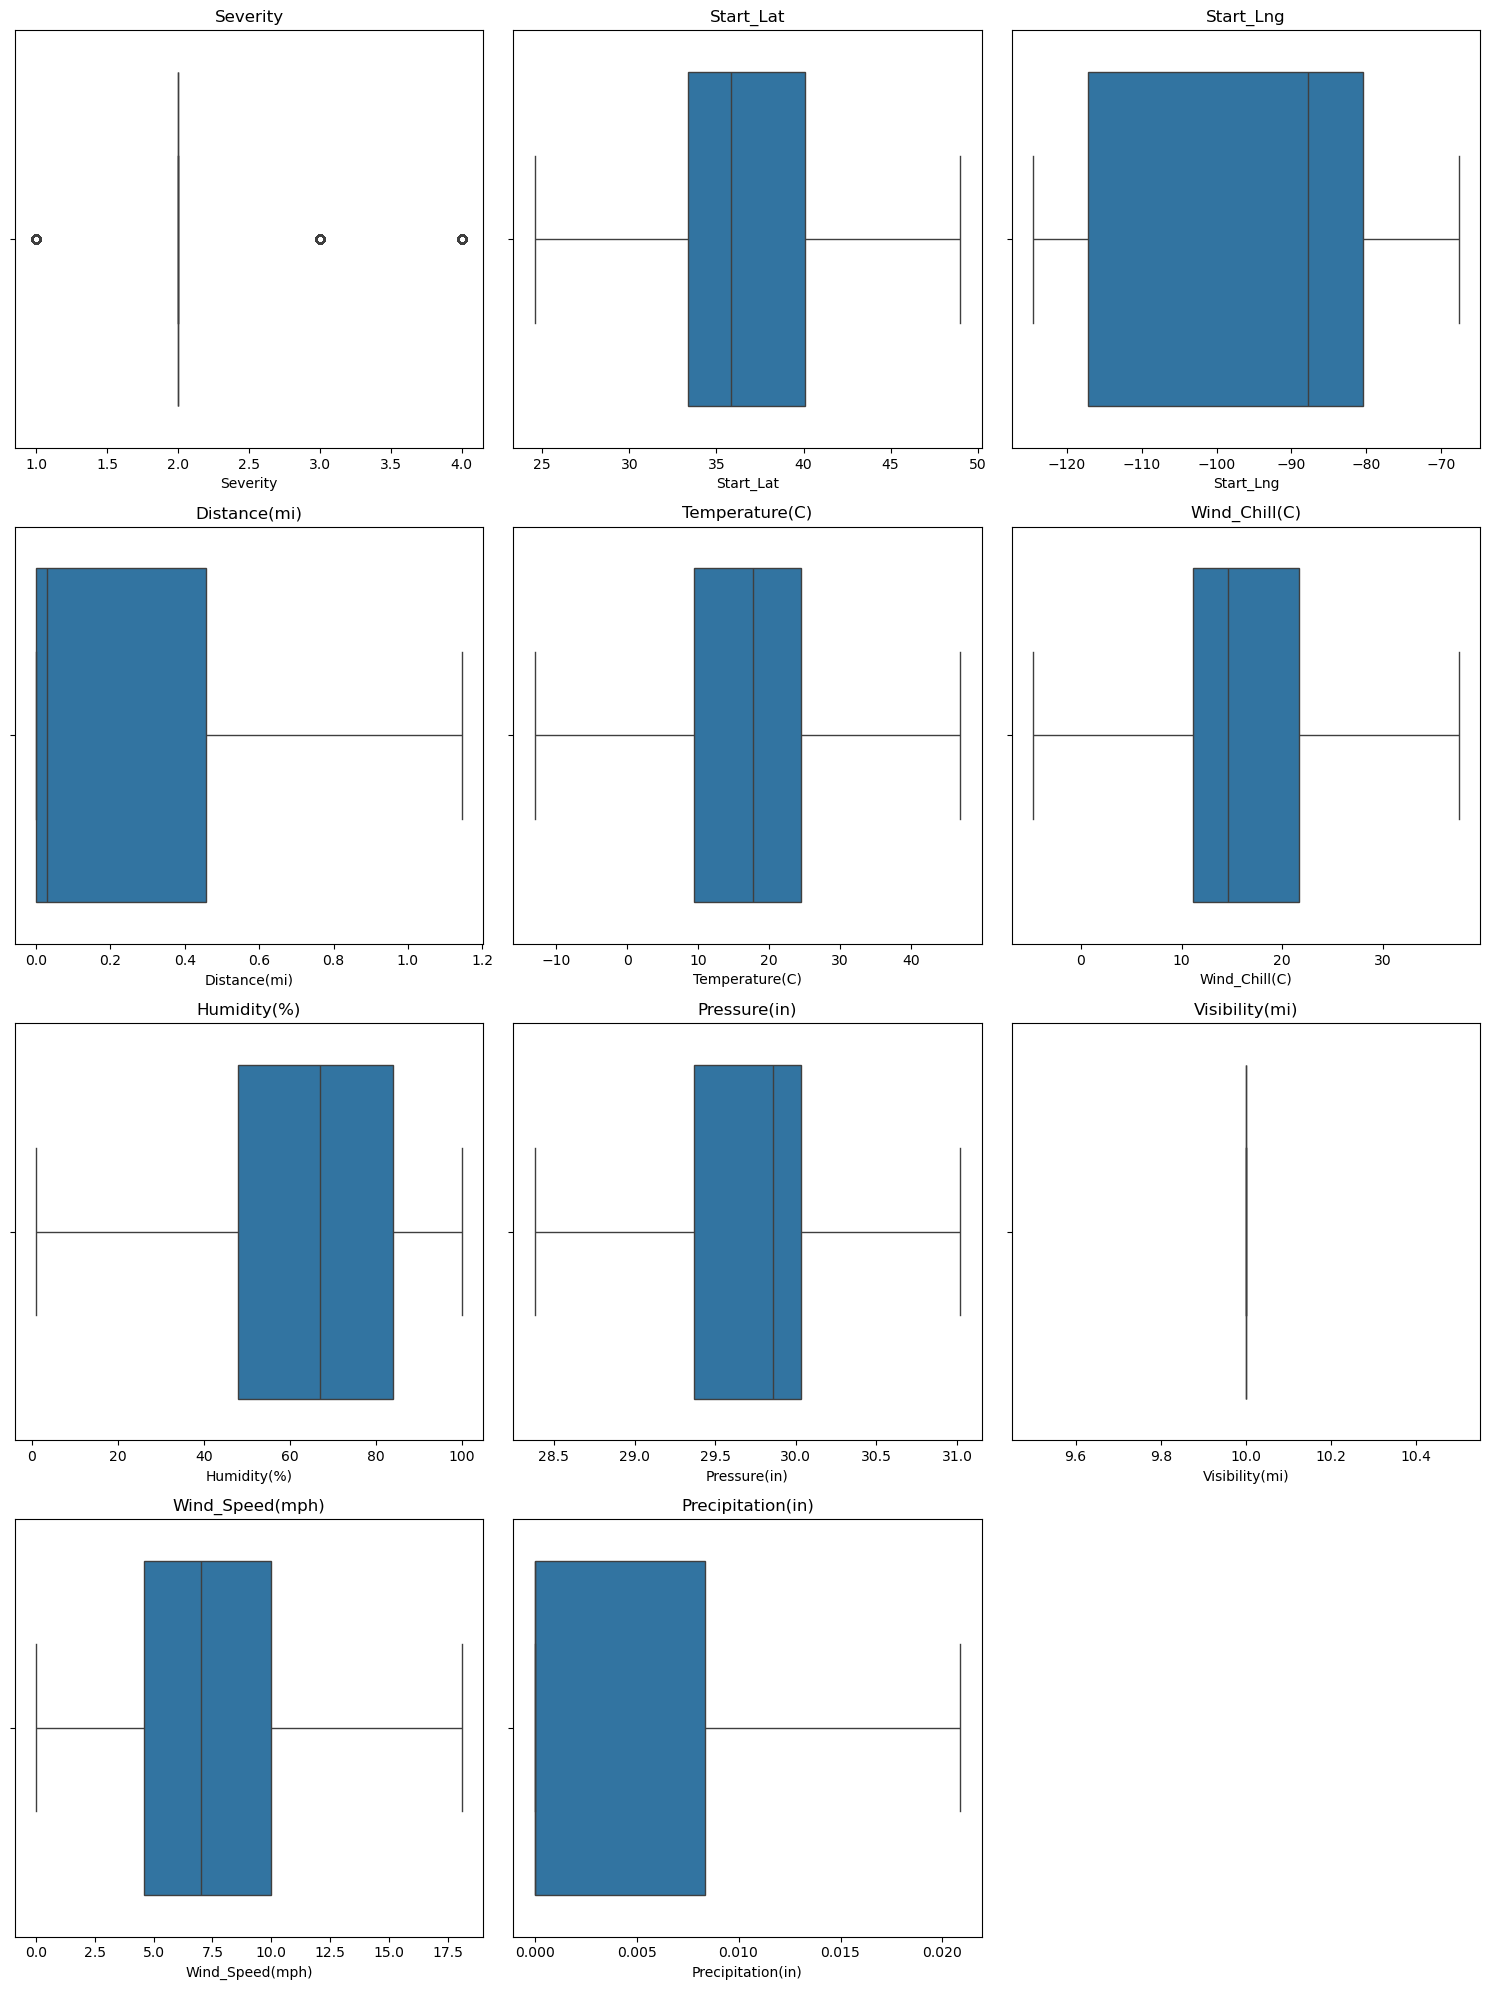

In [260]:
num_cols = 3
num_rows = (len(numerical_cols) - 1) // num_cols + 1

# Tạo figure và axes cho boxplot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

# Lặp qua các cột số để vẽ boxplot
for i, col in enumerate(numerical_cols):
    row = i // num_cols
    col_name = col  # Lưu tên cột
    col = i % num_cols
    sns.boxplot(x=df[col_name], ax=axes[row, col]) 
    axes[row, col].set_title(col_name)  

# Xóa các axes dư thừa nếu có
for i in range(len(numerical_cols), num_rows*num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

## 4.2 Xử lí Categorical Columns

In [261]:
catecalogical_cols = df.select_dtypes(include=[object,bool]).columns
df[catecalogical_cols].nunique().sort_values(ascending=False)[:8]

City                 10061
County                1661
Weather_Condition      115
State                   49
Wind_Direction          24
Timezone                 4
Station                  2
Nautical_Twilight        2
dtype: int64

- Nhận thấy có các cột có từ 2 đến 4 giá trị khác nhau, ta có thể thực hiện mã hoá bằng `One Hot Encoding.`
- Đối với các cột có nhiều phần tử hơn, mã hoá bằng cách trên có thể làm dữ liệu phức tạp và gây ra hiệu suất thấp của mô hình .Do đó để mã hoá các cột này, ta thực hiện cách mã hoá `Label Encoding`

In [262]:
#Import các thư viện hỗ trợ mã hoá
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import LabelEncoder


In [264]:
#Onehot encoding

#Chọn ra các cột cần mã hoá
one_hot_enc_cols=list(df.select_dtypes(include=[bool]).columns)
one_hot_enc_cols.extend(['Timezone','Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'])

#Tạo dataframe chứa các cột cần mã hoá
one_hot_df=df[one_hot_enc_cols]

#Tạo encoder
enc = OneHotEncoder(handle_unknown='ignore')

#Fit và transform dữ liệu
enc.fit(one_hot_df)
enc.categories_
enc.transform(one_hot_df).toarray()

#Tạo dataframe mới từ dữ liệu đã mã hoá
df.drop(one_hot_enc_cols, axis=1, inplace=True)
one_hot_df = pd.DataFrame(enc.transform(one_hot_df).toarray(), columns=enc.get_feature_names_out(one_hot_enc_cols))
one_hot_df
df = pd.concat([df, one_hot_df], axis=1)

In [265]:
#Label encoding
target_enc_cols = ['City','County','State','Wind_Direction','Weather_Condition']

for col in target_enc_cols:
    #Label encoding
    label_enc = LabelEncoder()
    df[col] = label_enc.fit_transform(df[col])

## 4.3 Xử lí Datetime Columns 

- Chuyển kiểu dữ liệu các cột dạng date time cũng thực hiện mã hoá bằng cách Label Encoding 

In [267]:
date_time_cols=['Start_Time','End_Time','Weather_Timestamp']

for col in date_time_cols:
    
    #Label encoding
    label_enc = LabelEncoder()
    df[col] = label_enc.fit_transform(df[col])

In [268]:
X_data=df.drop('Severity',axis=1)
y_data=df['Severity']-1

#Chia dữ liệu thành tập train và tập test
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

#Chuyển sang numpy 
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [269]:
#Kiểm tra lại dữ liệu sau khi tiền xử lý
print('Shape of X_train:',X_train.shape)
print('Shape of X_test:',X_test.shape)
print('Shape of y_train:',y_train.shape)
print('Shape of y_test:',y_test.shape)

Shape of X_train: (608641, 54)
Shape of X_test: (152161, 54)
Shape of y_train: (608641,)
Shape of y_test: (152161,)


## 4.4 Chuẩn hoá dữ liệu

- Chuẩn hoá dữ liệu min-max

In [270]:
from sklearn import preprocessing

In [271]:
scaler_X_train = preprocessing.StandardScaler().fit(X_train)
scaler_X_test = preprocessing.StandardScaler().fit(X_test)

X_train = scaler_X_train.transform(X_train)
X_test= scaler_X_test.transform(X_test)


## 4.4 Tạo model

In [272]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleANN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleANN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  
        return x


In [273]:
from torch.utils.data import TensorDataset, DataLoader

# Xây dựng data loader cho tập train
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

# Tạo dataset và dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)


In [274]:
# 4 classes
model = SimpleANN(X_train.shape[1], 4)

#Chọn hàm loss và optimizer
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

## 4.5 Tiến hành học model

In [296]:
def train(model, dataloader, epochs):
    model.train()
    losses=[]    #List chứa giá trị loss sau mỗi epoch
    for epoch in range(epochs):
        correct=0
        for data, target in dataloader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(output, 1) 
            correct+= (predicted == target).sum().item()   #Số lượng dự đoán đúng
            
            
        accuracy = 100 * correct / len(dataloader.dataset)
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Accuracy: {accuracy}%')
        losses.append(loss.item())
    return losses
# Huấn luyên mô hình
losses=train(model, train_loader, 100)


Epoch 1, Loss: 0.7808571457862854, Accuracy: 83.77598617247277%
Epoch 2, Loss: 1.8026782274246216, Accuracy: 83.82560491324114%
Epoch 3, Loss: 0.7530507445335388, Accuracy: 83.82675501650398%
Epoch 4, Loss: 3.3065876960754395, Accuracy: 83.82790511976683%
Epoch 5, Loss: 0.05642909184098244, Accuracy: 83.79570222840722%
Epoch 6, Loss: 0.1676325649023056, Accuracy: 83.79685233167007%
Epoch 7, Loss: 0.01011554803699255, Accuracy: 83.79340202188153%
Epoch 8, Loss: 0.13945099711418152, Accuracy: 83.80342435031488%
Epoch 9, Loss: 0.09301039576530457, Accuracy: 83.82494771137665%
Epoch 10, Loss: 0.7504971623420715, Accuracy: 83.86109381392315%
Epoch 11, Loss: 4.672640323638916, Accuracy: 83.78436549624492%
Epoch 12, Loss: 0.6259114146232605, Accuracy: 83.7705642570908%
Epoch 13, Loss: 0.10721053928136826, Accuracy: 83.79373062281378%
Epoch 14, Loss: 0.04225853085517883, Accuracy: 83.83842034959854%
Epoch 15, Loss: 0.008807501755654812, Accuracy: 83.8277408193007%
Epoch 16, Loss: 0.00434882193

In [297]:
#Xây dựng dataframe chứa giá trị loss sau mỗi epoch
losses=pd.DataFrame(losses,columns=['Loss'])

#Thêm epoch 
losses['Epoch']=range(1,101)


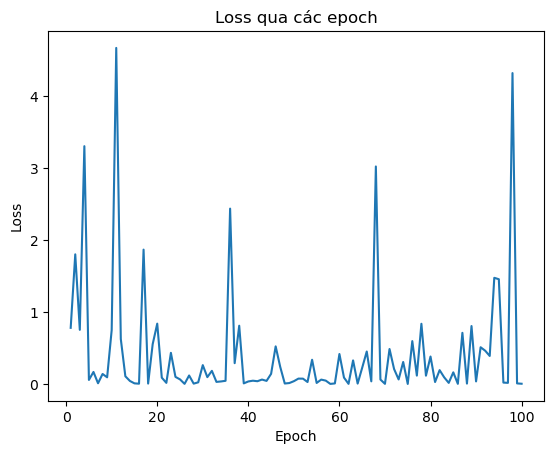

In [304]:
#Vẽ biểu đồ loss  qua các epoch
plt.plot(losses['Epoch'],losses['Loss'])
plt.title('Loss qua các epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## 4.6 Đánh giá chất lượng mô hình

In [301]:
# Lưu lại model để back up
torch.save(model.state_dict(), 'model_weights.pth')

In [302]:
# Đọc lại model
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()  # Đặt mô hình vào chế độ đánh giá


#Đánh giá acc của hàm test

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

def test(model, dataloader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in dataloader:
            output = model(data)
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()
    accuracy = 100 * correct / len(dataloader.dataset)
    print(f'Accuracy: {accuracy}%')
    
test(model, test_loader)
    

Accuracy: 83.58120674811548%


- Vậy kết quả chính xác trên tập test khoảng 83.58% , kết quả này có vẻ không cao trong thực tế, tuy nhiên mô hình xây dựng cũng tương đối đơn gian ở cả bước chuẩn bị dữ liệu lẫn xây dựng mô hình .Do đó kết quả cũng tương đối khả quan với mô hình đơn giản trên.